In [43]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# importar callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# importar loadmodel
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

import matplotlib.pyplot as plt

import nltk 

from nltk.translate.bleu_score import corpus_bleu,sentence_bleu



In [2]:
# Importar archivo .csv
df = pd.read_csv('../File/df_corpus_linguistico_preprocesado.csv',
                 sep='\t', encoding='utf-8', index_col=0)
df.head()


,source,target,preprocess_source,preprocess_target
id,,,,
10151431,I always say that one of the most important th...,Siempre digo que una de las cosas más importan...,<start> i always say that one of the most impo...,<start> siempre digo que una de las cosas mas ...
5014881,Francis spent every night when he was outside ...,Francisco pasó todas las noches que estuvo fue...,<start> francis spent every night when he was ...,<start> francisco paso todas las noches que es...
9998244,Find Google- remove your Gmail account.,Encontrar Google- eliminar su cuenta de Gmail.,<start> find google remove your gmail account ...,<start> encontrar google eliminar su cuenta de...
11709695,"Anyways, apart from that the movie was finalized.","De todos modos, aparte de eso, la película fue...",<start> anyways apart from that the movie was ...,<start> de todos modos aparte de eso la pelicu...
5267593,Graphics Programming Black Book and the mindse...,El Libro Negro de la Programación Gráfica y la...,<start> graphics programming black book and th...,<start> el libro negro de la programacion graf...


In [3]:
df.shape

(100000, 4)

In [4]:
en_text = df['preprocess_source']
es_text = df['preprocess_target']


# Tokenizar frases


In [5]:
# Función para tokenizar el texto
def tokenization(lines):
    tokenizer = Tokenizer(num_words=10000)              
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [6]:
# Tokenizar el texto en inglés
en_tokenizer = tokenization(en_text)                   # num_words=10000 -> 10.000 palabras más frecuentes del corpus de inglés (source)
en_vocab_size = len(en_tokenizer.word_index) + 1

en_length = max(len(line.split()) for line in en_text)
print(f'English Vocabulary Size: {en_vocab_size}')
print(f'English Max Length: {en_length}')


English Vocabulary Size: 43725
English Max Length: 108


In [7]:
# Tokenizar el texto en español
es_tokenizer = tokenization(es_text)                   # num_words=10000 -> 10.000 palabras más frecuentes del corpus de español (target
es_vocab_size = len(es_tokenizer.word_index) + 1

es_length = max(len(line.split()) for line in es_text)
print(f'Spanish Vocabulary Size: {es_vocab_size}')
print(f'Spanish Max Length: {es_length}')

Spanish Vocabulary Size: 56158
Spanish Max Length: 109


## Gráfica de distribución de longitud de las frases

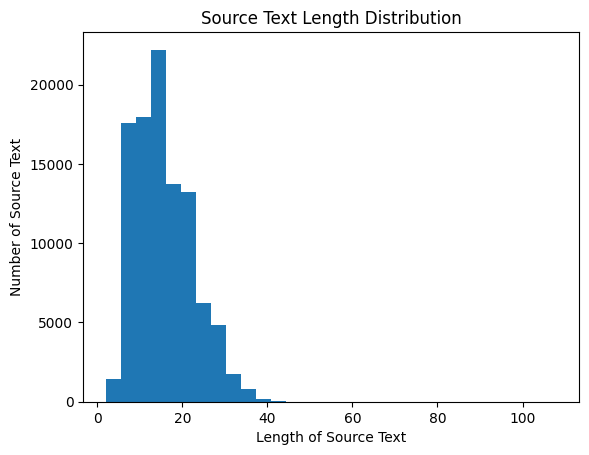

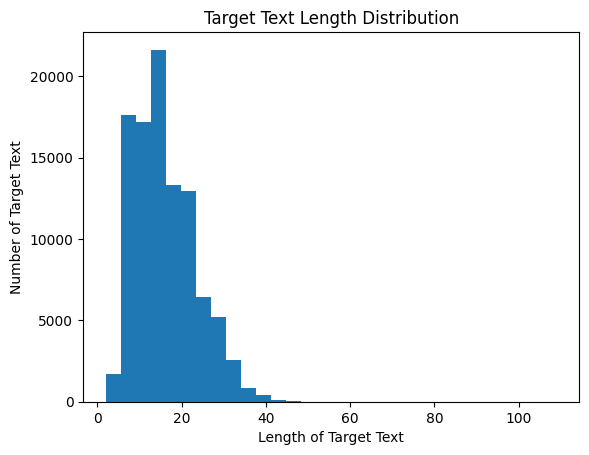

In [8]:
# Gráfica de distribución de longitud de las frases


length_en_text = [len(line.split()) for line in en_text]
length_es_text = [len(line.split()) for line in es_text]

plt.hist(length_en_text, bins=30)
# Etiquetas
plt.xlabel('Length of Source Text')
plt.ylabel('Number of Source Text')
plt.title('Source Text Length Distribution')
plt.show()

plt.hist(length_es_text, bins=30)
# Etiquetas
plt.xlabel('Length of Target Text')
plt.ylabel('Number of Target Text')
plt.title('Target Text Length Distribution')
plt.show()



Nota: 
Luego de representar gráficamente la distribución de la longitud de las frases, se observa una distribución sesgada hacia la derecha, por lo que se procede a truncar las frases a un máximo de 40 palabras.

In [9]:
en_length = 40
es_length = 40

## Gráfico con el total de palabras únicas de cada idioma en el corpus 

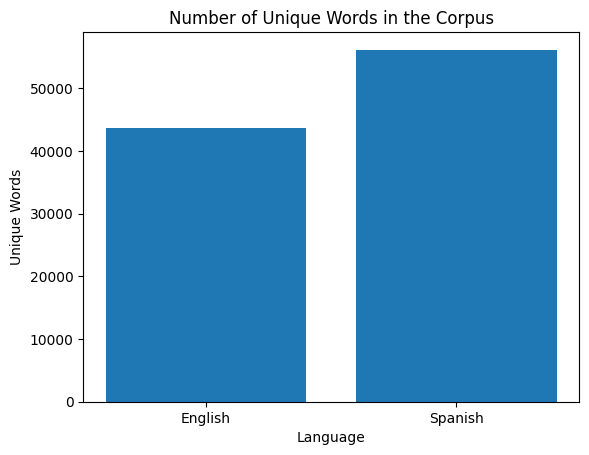

In [10]:

plt.bar(['English', 'Spanish'], [en_vocab_size, es_vocab_size])
# Etiquetas
plt.xlabel('Language')
plt.ylabel('Unique Words')
plt.title('Number of Unique Words in the Corpus')

plt.show()

Nota: 
Se puede observar que el número de palabras únicas en el corpus asciende a más de 40.000 palabras en ambos idiomas. Se decide tomar las 10.000 palabras más frecuentes en el corpus para reducir el tamaño del vocabulario y mejorar el rendimiento del modelo.


## Codificar secuencias de texto a entero

In [11]:

def encode_sequences(tokenizer, length, lines):
    # Entrenar el modelo de codificación
    seq = tokenizer.texts_to_sequences(lines)
    # Rellenar las secuencias con 0's para que tengan la misma longitud
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq


In [12]:
# Dividir el dataset en train y test

train, test = train_test_split(df, test_size=0.2, random_state=42)


In [13]:
# Codificar el texto en inglés
trainX = encode_sequences(en_tokenizer, en_length, train['preprocess_source'])
testX = encode_sequences(en_tokenizer, en_length, test['preprocess_source'])

# Codificar el texto en español
trainY = encode_sequences(es_tokenizer, es_length, train['preprocess_target'])
testY = encode_sequences(es_tokenizer, es_length, test['preprocess_target'])


## Definir el modelo

In [14]:
# Definir el modelo
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units,
              input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model


In [15]:
en_vocab_size = 10000
es_vocab_size = 10000

In [16]:

model = define_model(en_vocab_size, es_vocab_size, en_length, es_length, 128)


In [17]:

model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           131584    
                                                                 
 time_distributed (TimeDistr  (None, 40, 10000)        1290000   
 ibuted)                                                

In [ ]:
# Embeding (None, 40, 128): significa que tenemos 40 palabras de entrada y 128 dimensiones de salida
# LSTM (None, 128): significa que tenemos 128 dimensiones de salida
# RepeatVector (None, 40, 128): significa que tenemos 40 palabras de salida y 128 dimensiones de salida


In [29]:
filename = '../File/Model/model151S.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history =  model.fit(trainX, trainY, 
                     
                     
                     epochs=15, batch_size=256, validation_data=(testX, testY), callbacks=[checkpoint] , verbose=1)  



Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 1.8697 - accuracy: 0.7064
Epoch 1: val_loss improved from inf to 1.98027, saving model to ../File/Model/model151S.h5
313/313 [==============================] - 591s 2s/step - loss: 1.8697 - accuracy: 0.7064 - val_loss: 1.9803 - val_accuracy: 0.6935
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 1.8460 - accuracy: 0.7081
Epoch 2: val_loss improved from 1.98027 to 1.96235, saving model to ../File/Model/model151S.h5
313/313 [==============================] - 600s 2s/step - loss: 1.8460 - accuracy: 0.7081 - val_loss: 1.9624 - val_accuracy: 0.6936
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 1.8237 - accuracy: 0.7094
Epoch 3: val_loss improved from 1.96235 to 1.95099, saving model to ../File/Model/model151S.h5
313/313 [==============================] - 621s 2s/step - loss: 1.8237 - accuracy: 0.7094 - val_loss: 1.9510 - val_accuracy: 0.6928
Epoch 4/15
313/313 [===============

In [32]:
# Cargar el modelo
model = load_model('../File/Model/model151S.h5')

## Evaluación del modelo

In [21]:
# Evaluar el modelo para 15 epochs

score_train = model.evaluate(trainX, trainY)

print('Train loss:', score_train[0])        
print('Train accuracy:', score_train[1])

score_test = model.evaluate(testX, testY)

print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

2500/2500 [==============================] - 201s 80ms/step - loss: 1.8635 - accuracy: 0.7075
Train loss: 1.8635072708129883
Train accuracy: 0.7075477838516235
625/625 [==============================] - 70s 113ms/step - loss: 2.0009 - accuracy: 0.6933
Test loss: 2.0008528232574463
Test accuracy: 0.6932962536811829


In [30]:
# Evaluar el modelo para 30 epochs

score_train = model.evaluate(trainX, trainY)

print('Train loss:', score_train[0])        
print('Train accuracy:', score_train[1])

score_test = model.evaluate(testX, testY)

print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

2500/2500 [==============================] - 382s 153ms/step - loss: 1.5279 - accuracy: 0.7327
Train loss: 1.5278743505477905
Train accuracy: 0.7327162623405457
625/625 [==============================] - 105s 168ms/step - loss: 1.8280 - accuracy: 0.7016
Test loss: 1.8279999494552612
Test accuracy: 0.7015824913978577


Nota:<br><br>
En el conjunto de entrenamiento, la pérdida (loss) es de aproximadamente 1.52 y la precisión (accuracy) es de alrededor del 73.27%. Esto indica que el modelo ha logrado ajustarse a los datos de entrenamiento y puede predecir correctamente el 73.27% de las frases en este conjunto.

En el conjunto de prueba, la pérdida es de aproximadamente 1.82 y la precisión es de alrededor del 70.16%. Estos resultados son similares a los obtenidos en el conjunto de entrenamiento, lo cual es un indicio de que el modelo no está sobreajustado y generaliza bien a datos no vistos previamente.

Con un tamaño de vocabulario de 10,000 palabras únicas y 100,000 muestras de entrenamiento se logró una precisión del 70.16% en el conjunto de prueba, siendo bastante bueno, considerando que hay una gran cantidad de palabras y muestras involucradas.

El modelo LSTM está aprendiendo patrones relevantes para la traducción de frases de inglés a español y que tiene un desempeño razonablemente bueno en términos de precisión.

Pero se debe evaluar otras métricas para ver cuán bien está generalizando el modelo

### Gráfica sobre los valores de pérdida y presición del historial del modelo

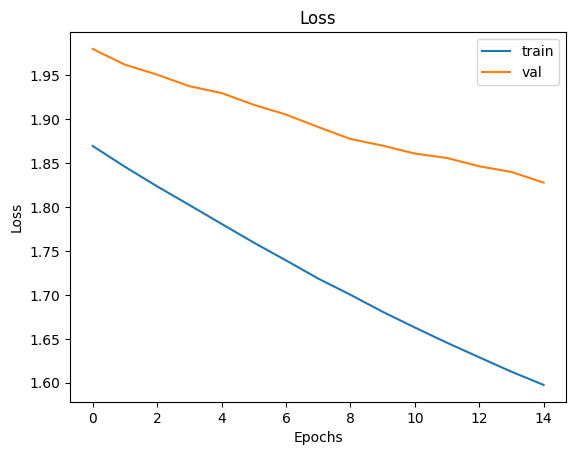

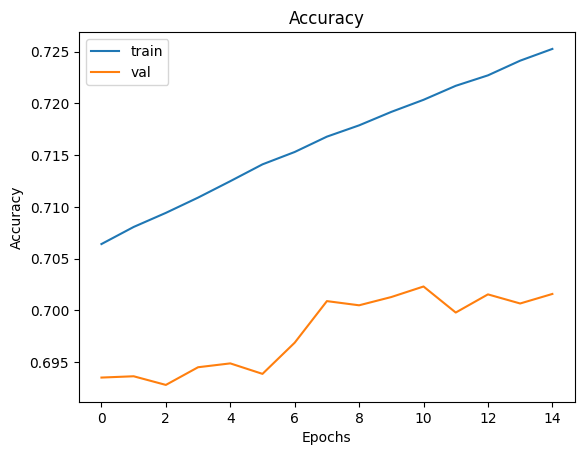

In [33]:
# Valores de pérdida y precisión del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Gráfica de la pérdida
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Gráfica de la precisión
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

*Gráfica de Pérdida:*
- La gráfica de pérdida muestra cómo la pérdida (error) del modelo evoluciona a lo largo de las épocas de entrenamiento.
- El eje horizontal representa el número de épocas, mientras que el eje vertical representa el valor de pérdida.
- Se muestra que la pérdida va disminuyendo a medida que aumentan las épocas.
- Se observa que la línea de pérdida de entrenamiento (train loss) disminuye y se mantiene cerca de la línea de pérdida de validación (validation loss), indica que el modelo está aprendiendo correctamente y generalizando bien.

*Gráfica de Precisión:*
- La gráfica de precisión muestra cómo la precisión del modelo evoluciona a lo largo de las épocas de entrenamiento.
- El eje horizontal representa el número de épocas, mientras que el eje vertical representa el valor de precisión.
- Se observa que la precisión aumente a medida que aumentan las épocas.

En resumen, durante el entrenamiento:

- La pérdida disminuya y la precisión aumente.
- Estas gráficas brindan información visual sobre cómo el modelo está progresando durante el entrenamiento. 
- Se debería seguir entrenando con más épocas


Pero estas métricas no son suficiente para evaluar modelos de traducción. Es importante tener en cuenta otros aspectos del rendimiento del modelo, como las métricas de evaluación (por ejemplo, BLEU, METEOR, ROUGE) y realizar una revisión manual de las traducciones generadas para tener una evaluación más completa del desempeño de tu modelo de traducción.

## Predecir

In [34]:
# Función get_word

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [64]:
# Función para predecir una secuencia

def predict_sequence(model, input_sentence):
    inputs = []
    for i in input_sentence.split():
        if i in en_tokenizer.word_index:
            inputs.append(en_tokenizer.word_index[i])

    inputs = pad_sequences([inputs], maxlen=en_length, padding='post')

    temp = []
    for i in inputs[0]:
        t = get_word(i, es_tokenizer)
        if i > 0:
            if (t == get_word(i-1, es_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t)

    print(' '.join(temp))
    aux = ' '.join(temp)
    # strim() elimina los espacios en blanco
    return aux.strip()
    return

# Función para prededir varias secuencias


def predict_multiple_sequences(model, input_sentences):
    pred = []
    for i in input_sentences:
        pred.append(predict_sequence(model, i))
        print('\n')
    return pred


In [65]:
predict_sequence(model, 'i love you')

que estaba es                                     


'que estaba es'

Se observa que el modelo no predice correctamente la secuencia de salida en español para la secuencia de entrada en inglés 'i love you'. 
Esto se debe a que el modelo no ha sido entrenado con suficientes epochs. 

In [66]:
test['preprocess_target'][30:40]

id
9195670                      <start> para el quad de ?  <end>
3353300           <start> avestruz y corral lo tengo .  <end>
5137219     <start> te da algo de estabilidad cuando tiene...
5759567     <start> sus canciones estan bien wrought y en ...
3761092     <start> a continuacion mi valoracion de las ca...
5158646     <start> queda muy bien con el banco de clavija...
3364697                     <start> la trufa blanca es  <end>
1190033     <start> no necesito estar comodo mientras el g...
11782773    <start> podria seguir durante mucho tiempo de ...
11375468    <start> wordpress es un sistema de gestion de ...
Name: preprocess_target, dtype: object

In [69]:
test_data = test['preprocess_source'][30:40]
pred = predict_multiple_sequences(model, test_data)


una de un tradicionalmente                                    


interactue y tocaba sea no                                   


pocos es sobre adivina tengo es las la dijeron y a solo una ligeramente por el bonitas un de jugador la meses mucho en de antes              


ya nuestra este estos oficios y por historia constantemente ya hice en alfiler gusto interminables ademas                        


puerta a como fuerza comedia                                   


hubiera solo me de toallas el juro barrios                                


de contenido promocional a                                    


que te se lugar la del queda mas leer mas de envio a nuestro                          


que cada parte por una altas tener pero no con hay los desde a                          


caracteristica a el equipo minimo sigue gente la tenian rango suelo                             




In [71]:
print(pred)
print('\n')
print(np.array(test_data))



['una de un tradicionalmente', 'interactue y tocaba sea no', 'pocos es sobre adivina tengo es las la dijeron y a solo una ligeramente por el bonitas un de jugador la meses mucho en de antes', 'ya nuestra este estos oficios y por historia constantemente ya hice en alfiler gusto interminables ademas', 'puerta a como fuerza comedia', 'hubiera solo me de toallas el juro barrios', 'de contenido promocional a', 'que te se lugar la del queda mas leer mas de envio a nuestro', 'que cada parte por una altas tener pero no con hay los desde a', 'caracteristica a el equipo minimo sigue gente la tenian rango suelo']


['<start> for the in quad ?  <end>'
 '<start> ostrich and barnyard got it .  <end>'
 '<start> gives you some stability when you have to reach and is great for hanging on a hook in the garage to keep out of the way .  <end>'
 '<start> his songs are well wrought and on most tracks his sense of lyricism comes shining through .  <end>'
 '<start> below is my track rating .  <end>'
 '<start>

In [79]:
references = [
    'para el en quad?',
    'avestruz y corral lo consiguieron.',
    'le da algo de estabilidad cuando tiene que alcanzar y es ideal para colgar en un gancho en el garaje para no estorbar.',
    'sus canciones están bien elaboradas y en la mayoría de las pistas brilla su sentido del lirismo.',
    'abajo está mi calificación de la pista.',
    'va muy bien con la libra un banco de clavijas.',
    'la trufa blanca es',
    "No necesito estar cómodo mientras el gato esté feliz",
    'podría seguir durante mucho tiempo, pero es como esta película. . .',
    'wordpress es un sistema de administración de contenido que se utiliza para crear sitios de blogs.']




In [80]:
print(references)

['para el en quad?', 'avestruz y corral lo consiguieron.', 'le da algo de estabilidad cuando tiene que alcanzar y es ideal para colgar en un gancho en el garaje para no estorbar.', 'sus canciones están bien elaboradas y en la mayoría de las pistas brilla su sentido del lirismo.', 'abajo está mi calificación de la pista.', 'va muy bien con la libra un banco de clavijas.', 'la trufa blanca es', 'No necesito estar cómodo mientras el gato esté feliz', 'podría seguir durante mucho tiempo, pero es como esta película. . .', 'wordpress es un sistema de administración de contenido que se utiliza para crear sitios de blogs.']


In [81]:
print(pred)

['una de un tradicionalmente', 'interactue y tocaba sea no', 'pocos es sobre adivina tengo es las la dijeron y a solo una ligeramente por el bonitas un de jugador la meses mucho en de antes', 'ya nuestra este estos oficios y por historia constantemente ya hice en alfiler gusto interminables ademas', 'puerta a como fuerza comedia', 'hubiera solo me de toallas el juro barrios', 'de contenido promocional a', 'que te se lugar la del queda mas leer mas de envio a nuestro', 'que cada parte por una altas tener pero no con hay los desde a', 'caracteristica a el equipo minimo sigue gente la tenian rango suelo']


## Métrica BLUE

In [90]:


# media de las puntuaciones BLEU
score = 0
scores = []
for i in range(len(pred)):
    reference = [references[i].split()]
    candidate = pred[i].split()
    blue = sentence_bleu(reference, candidate)
    # guardar referencia canditada y score
    scores.append([" ".join(reference[0]), " ".join(candidate), blue])
    score += sentence_bleu(reference, candidate)

# scores a dataframe
scores = pd.DataFrame(scores, columns=['reference', 'candidate', 'score'])

print('Mean BLEU score -> {}'.format(score/len(pred)))
scores


Mean BLEU score -> 5.284164025604417e-232


/opt/homebrew/anaconda3/envs/deep_learning/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/anaconda3/envs/deep_learning/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/anaconda3/envs/deep_learning/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

,reference,candidate,score
0,para el en quad?,una de un tradicionalmente,0.000000e+00
1,avestruz y corral lo consiguieron.,interactue y tocaba sea no,1.218332e-231
2,le da algo de estabilidad cuando tiene que alc...,pocos es sobre adivina tengo es las la dijeron...,1.262708e-231
3,sus canciones están bien elaboradas y en la ma...,ya nuestra este estos oficios y por historia c...,1.017636e-231
4,abajo está mi calificación de la pista.,puerta a como fuerza comedia,0.000000e+00
5,va muy bien con la libra un banco de clavijas.,hubiera solo me de toallas el juro barrios,8.436498e-232
6,la trufa blanca es,de contenido promocional a,0.000000e+00
7,No necesito estar cómodo mientras el gato esté...,que te se lugar la del queda mas leer mas de e...,0.000000e+00
8,"podría seguir durante mucho tiempo, pero es co...",que cada parte por una altas tener pero no con...,9.418382e-232
9,wordpress es un sistema de administración de c...,caracteristica a el equipo minimo sigue gente ...,0.000000e+00
